In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re


In [2]:
def extract_course_num(course):
    match = re.search(r'(\d+)([A-Za-z]*)', course)
    if match:
        number = int(match.group(1))
        suffix = match.group(2)
        return (number, suffix)
    return (0, '')


In [18]:
df = pd.read_csv('webreg_data/results/enrollment_comparison_shared.csv')

quarter_order = ['Fall 2024', 'Winter 2025', 'Spring 2025']
df['quarter_label'] = pd.Categorical(
    df['quarter_label'], categories=quarter_order, ordered=True
)

required_courses = {
    'DSC_10', 'DSC_20', 'DSC_30', 'DSC_40A', 'DSC_40B',
    'DSC_80', 'DSC_100', 'DSC_102', 'DSC_106',
    'DSC_140A', 'DSC_140B', 'DSC_148',
    'DSC_180A', 'DSC_180B'
}

df['course_type'] = np.where(
    df['course'].isin(required_courses),
    'Required',
    'Elective'
)

sorted_courses = sorted(df['course'].unique(), key=lambda x: extract_course_num(x))
df['course'] = pd.Categorical(df['course'], categories=sorted_courses, ordered=True)

course_order = sorted_courses
x = np.arange(len(course_order))
width = 0.25

df.head()

,course,quarter,quarter_label,enrolled,available,waitlisted,total,time,utilization_rate,waitlist_rate,available_rate,course_type
0,DSC_10,fa24,Fall 2024,427,17,8,444,2024-11-24T22:03:51,96.17,1.8,3.83,Required
1,DSC_10,sp25,Spring 2025,108,42,0,150,2025-05-15T03:50:50,72.00,0.0,28.00,Required
2,DSC_10,wi25,Winter 2025,207,83,0,290,2025-01-31T12:41:46,71.38,0.0,28.62,Required
3,DSC_20,fa24,Fall 2024,74,76,0,150,2024-11-24T22:03:52,49.33,0.0,50.67,Required
4,DSC_20,sp25,Spring 2025,107,13,0,120,2025-05-15T03:50:51,89.17,0.0,10.83,Required


In [5]:
sns.set_style("whitegrid")
sns.set_palette("husl")

colors = {
    'enrolled': '#2ecc71',
    'waitlisted': '#e74c3c',
    'available': '#95a5a6',
    'total': '#3498db'
}

quarter_colors = {
    'Fall 2024': '#e67e22',
    'Winter 2025': '#9b59b6',
    'Spring 2025': '#3498db'
}


# Visualization 1 — Stacked Enrollment + Capacity

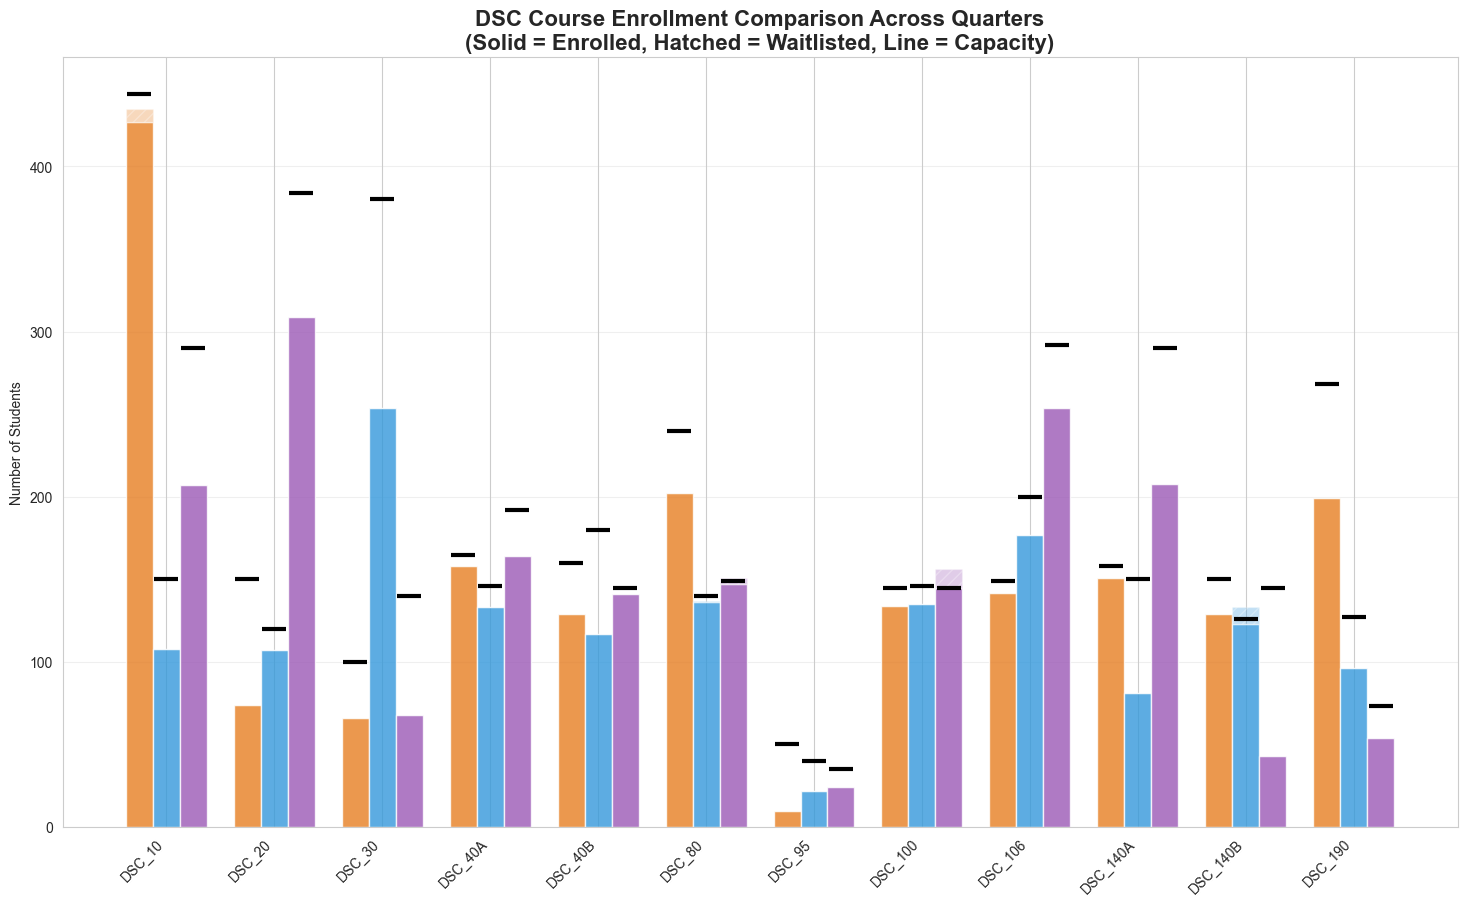

In [6]:
fig, ax = plt.subplots(figsize=(18, 10))

for i, quarter in enumerate(['Fall 2024', 'Spring 2025', 'Winter 2025']):
    q = df[df['quarter_label'] == quarter].sort_values('course')
    pos = x + (i - 1) * width

    ax.bar(pos, q['enrolled'], width, color=quarter_colors[quarter], alpha=0.8)
    ax.bar(pos, q['waitlisted'], width, bottom=q['enrolled'],
           color=quarter_colors[quarter], alpha=0.3, hatch='///')
    ax.scatter(pos, q['total'], color='black', marker='_', s=300, linewidths=3)

ax.set_title(
    'DSC Course Enrollment Comparison Across Quarters\n'
    '(Solid = Enrolled, Hatched = Waitlisted, Line = Capacity)',
    fontsize=16, fontweight='bold'
)
ax.set_xticks(x)
ax.set_xticklabels(course_order, rotation=45, ha='right')
ax.set_ylabel('Number of Students')
ax.grid(axis='y', alpha=0.3)

plt.show()


# Visualization 2 — Utilization Rate Comparison

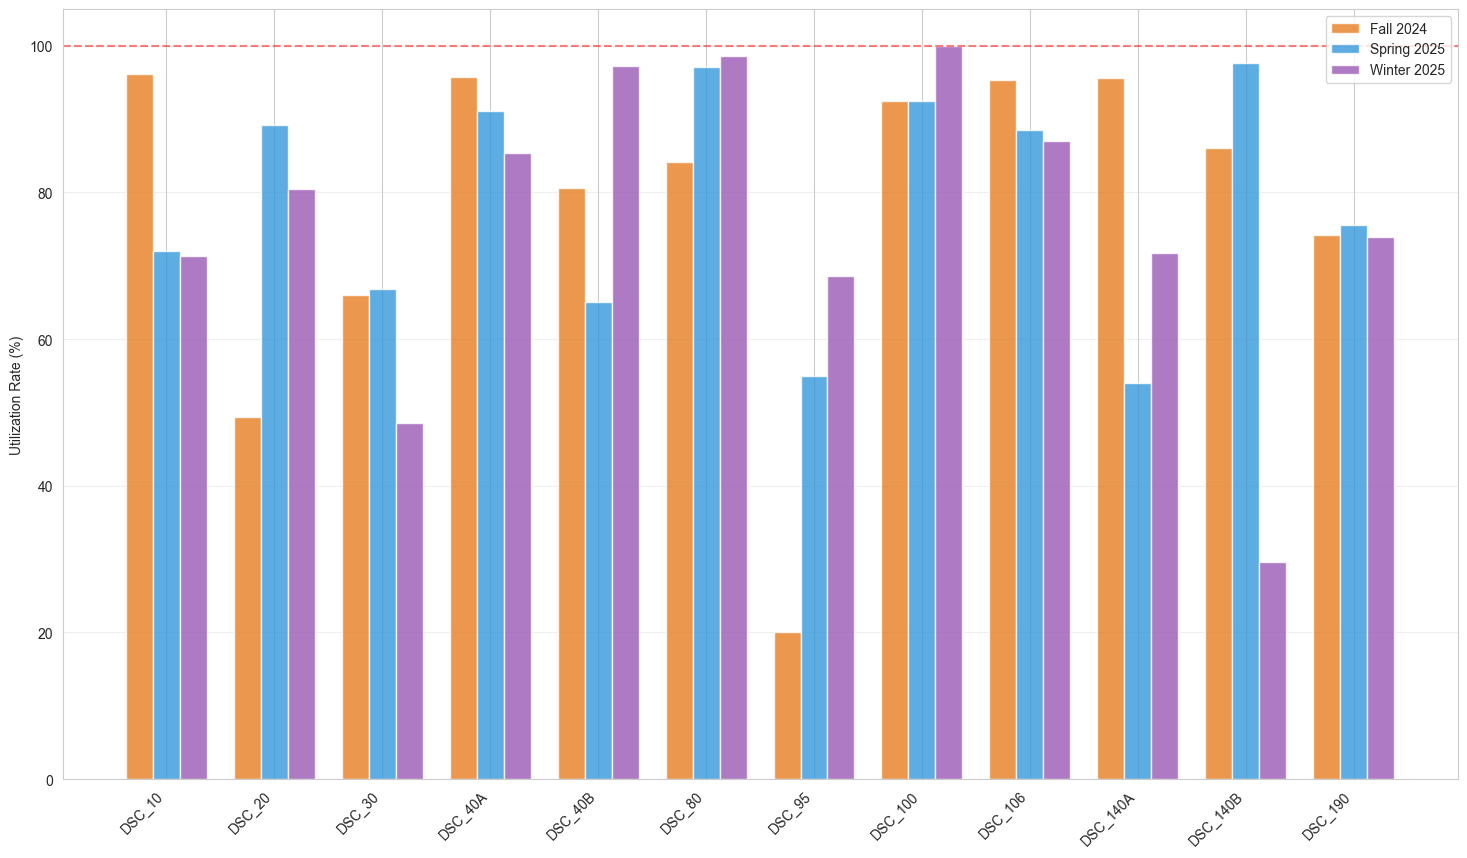

In [7]:
fig, ax = plt.subplots(figsize=(18, 10))

for i, quarter in enumerate(['Fall 2024', 'Spring 2025', 'Winter 2025']):
    q = df[df['quarter_label'] == quarter].sort_values('course')
    pos = x + (i - 1) * width
    ax.bar(pos, q['utilization_rate'], width,
           color=quarter_colors[quarter], alpha=0.8, label=quarter)

ax.axhline(100, color='red', linestyle='--', alpha=0.5)
ax.set_ylabel('Utilization Rate (%)')
ax.set_xticks(x)
ax.set_xticklabels(course_order, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.show()


# Visualization 3 — 100% Proportional Stacked Bars

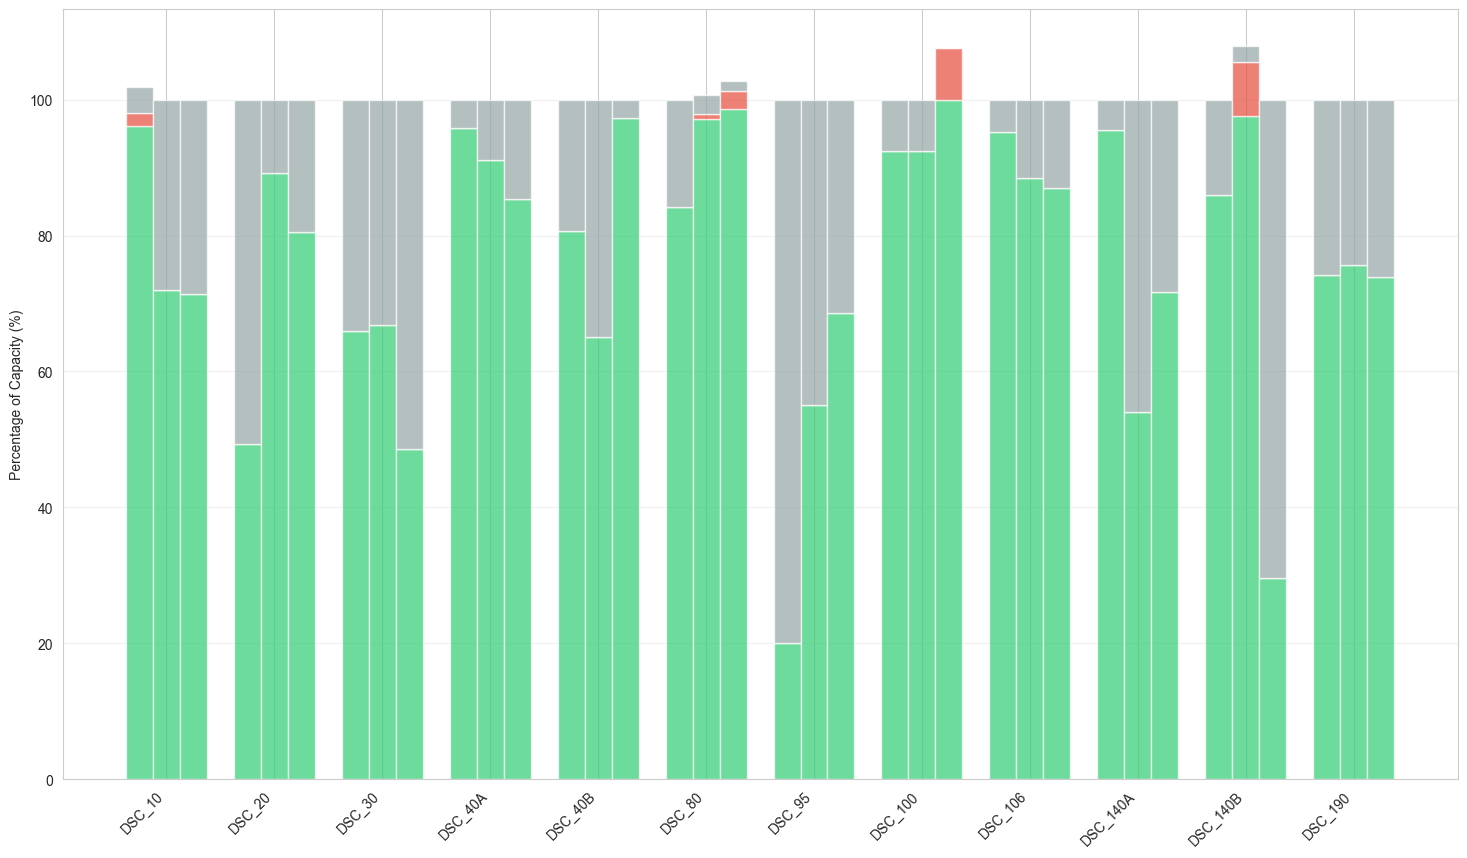

In [8]:
fig, ax = plt.subplots(figsize=(18, 10))

for i, quarter in enumerate(['Fall 2024', 'Spring 2025', 'Winter 2025']):
    q = df[df['quarter_label'] == quarter].sort_values('course')
    pos = x + (i - 1) * width

    ax.bar(pos, q['utilization_rate'], width, color=colors['enrolled'], alpha=0.7)
    ax.bar(pos, q['waitlist_rate'], width, bottom=q['utilization_rate'],
           color=colors['waitlisted'], alpha=0.7)
    ax.bar(pos, q['available_rate'], width,
           bottom=q['utilization_rate'] + q['waitlist_rate'],
           color=colors['available'], alpha=0.7)

ax.set_ylabel('Percentage of Capacity (%)')
ax.set_xticks(x)
ax.set_xticklabels(course_order, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.show()


# Visualization 4 — Faceted Course Comparisons

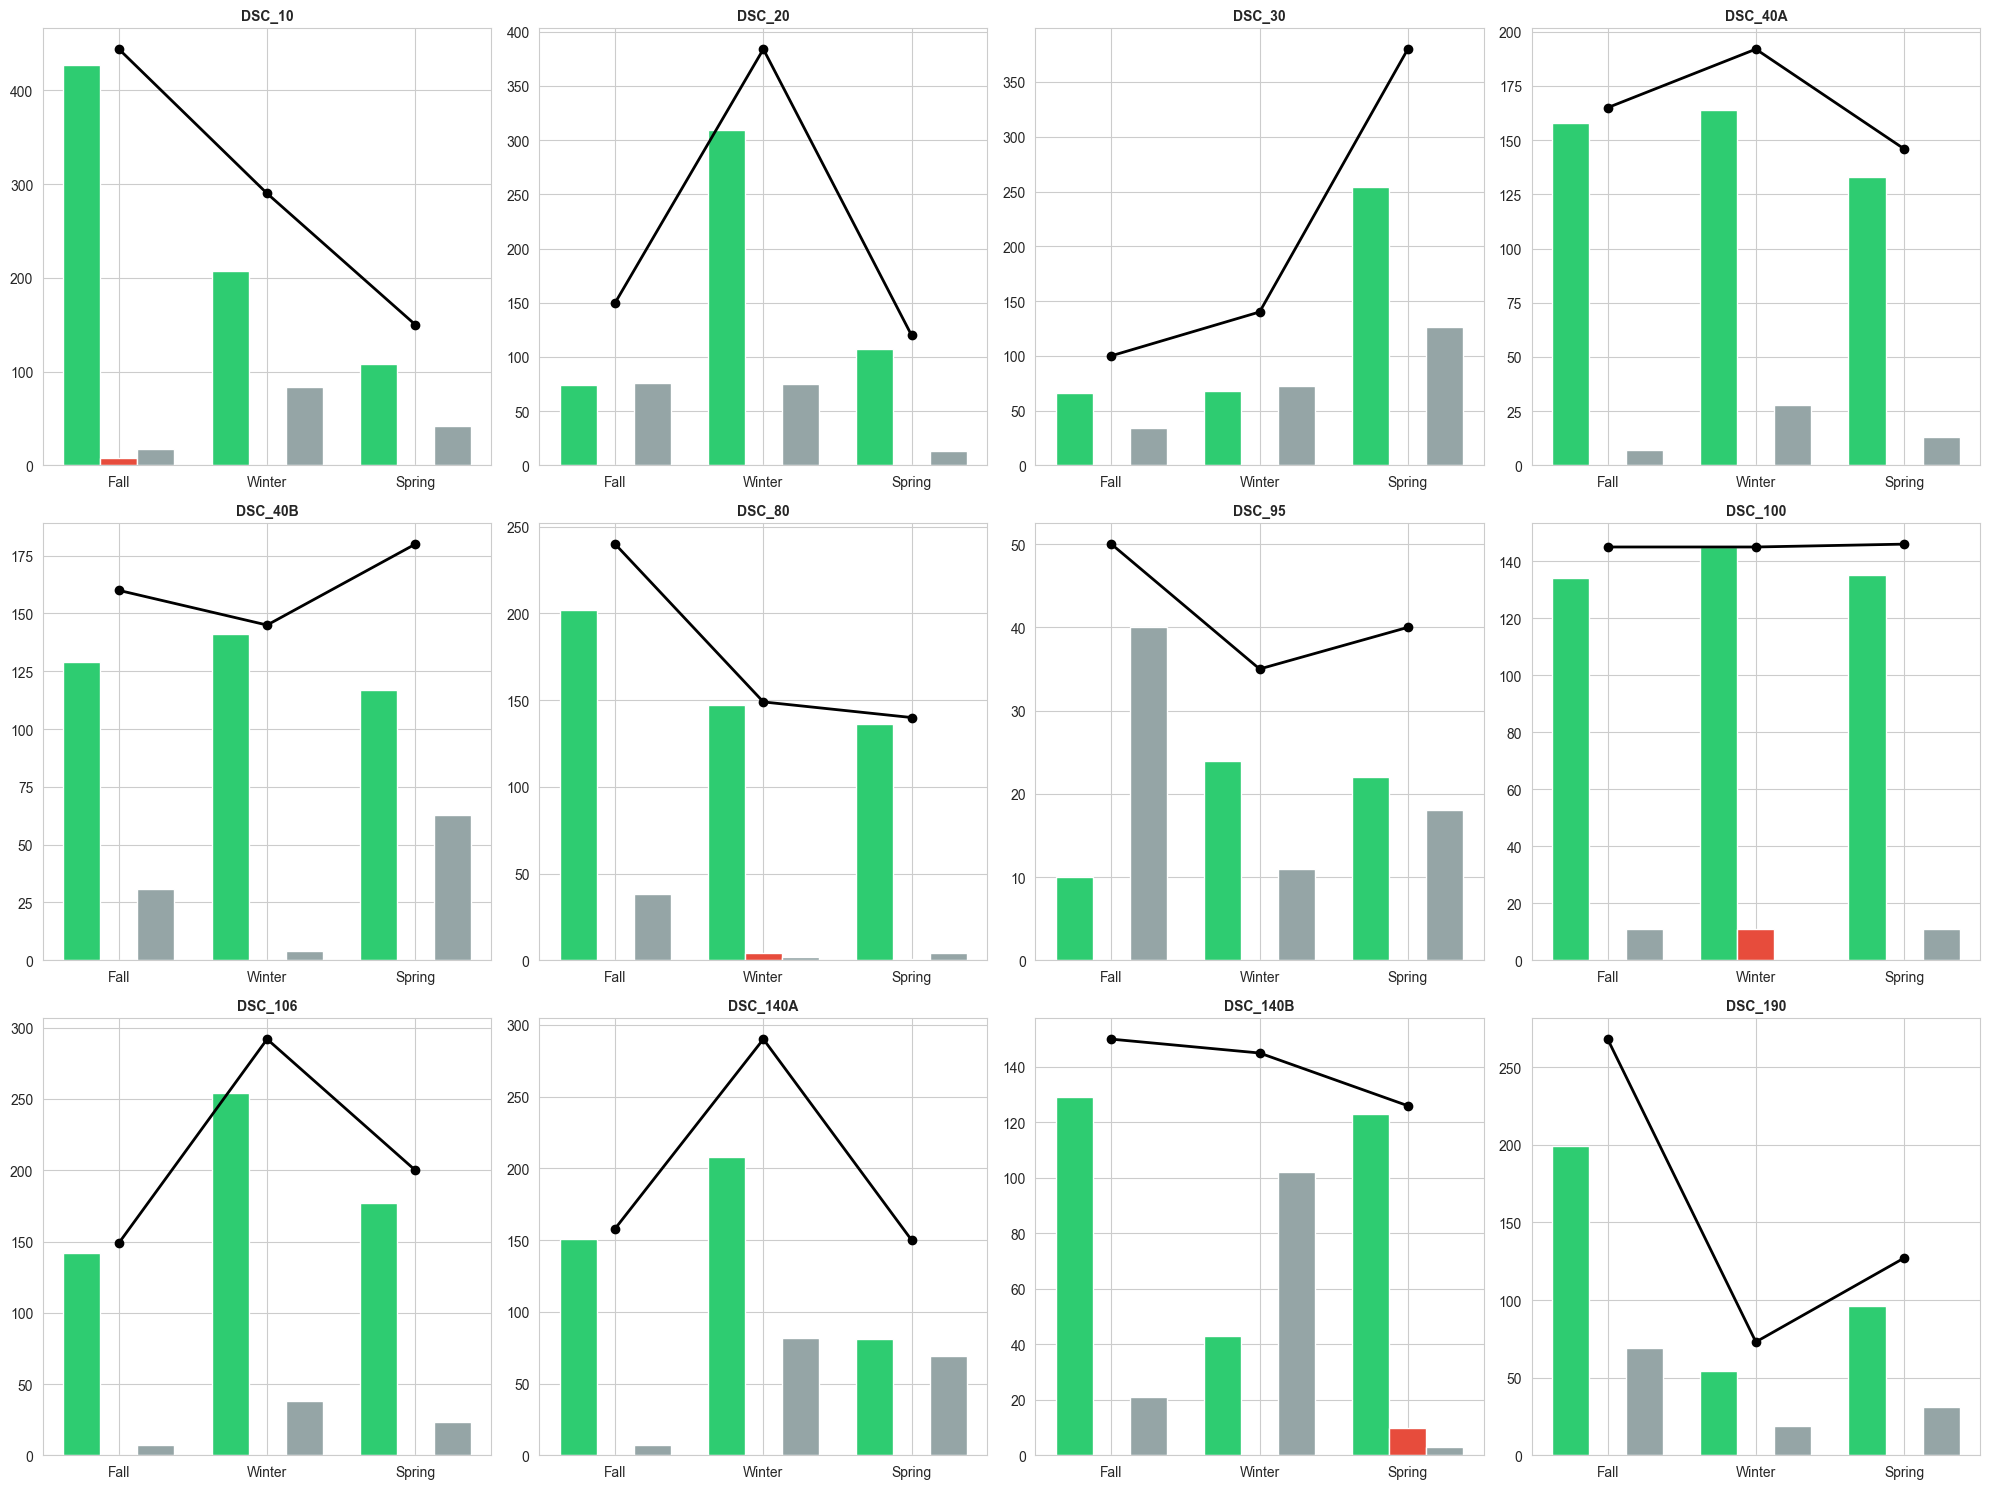

In [9]:
n_cols = 4
n_rows = int(np.ceil(len(course_order) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

for i, course in enumerate(course_order):
    ax = axes[i]
    c = df[df['course'] == course].sort_values('quarter_label')
    xp = np.arange(len(c))

    ax.bar(xp - width, c['enrolled'], width, color=colors['enrolled'])
    ax.bar(xp, c['waitlisted'], width, color=colors['waitlisted'])
    ax.bar(xp + width, c['available'], width, color=colors['available'])
    ax.plot(xp, c['total'], 'ko-', linewidth=2)

    ax.set_title(course, fontsize=10, fontweight='bold')
    ax.set_xticks(xp)
    ax.set_xticklabels([q.split()[0] for q in c['quarter_label']])

for j in range(len(course_order), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# Visualization 5 — Utilization Heatmap

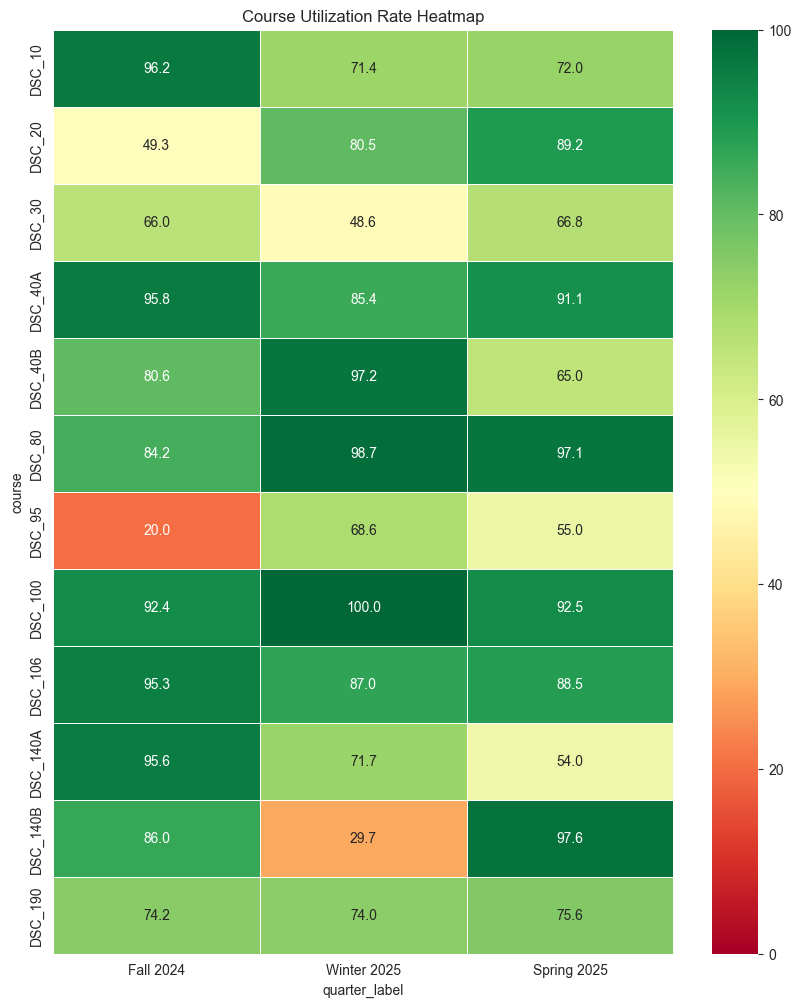

In [10]:
pivot = df.pivot(index='course', columns='quarter_label', values='utilization_rate')

plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot, annot=True, fmt='.1f', cmap='RdYlGn',
    vmin=0, vmax=100, linewidths=0.5
)
plt.title('Course Utilization Rate Heatmap')
plt.show()


# Visualization 6 — Comprehensive Multi-Metric Dashboard

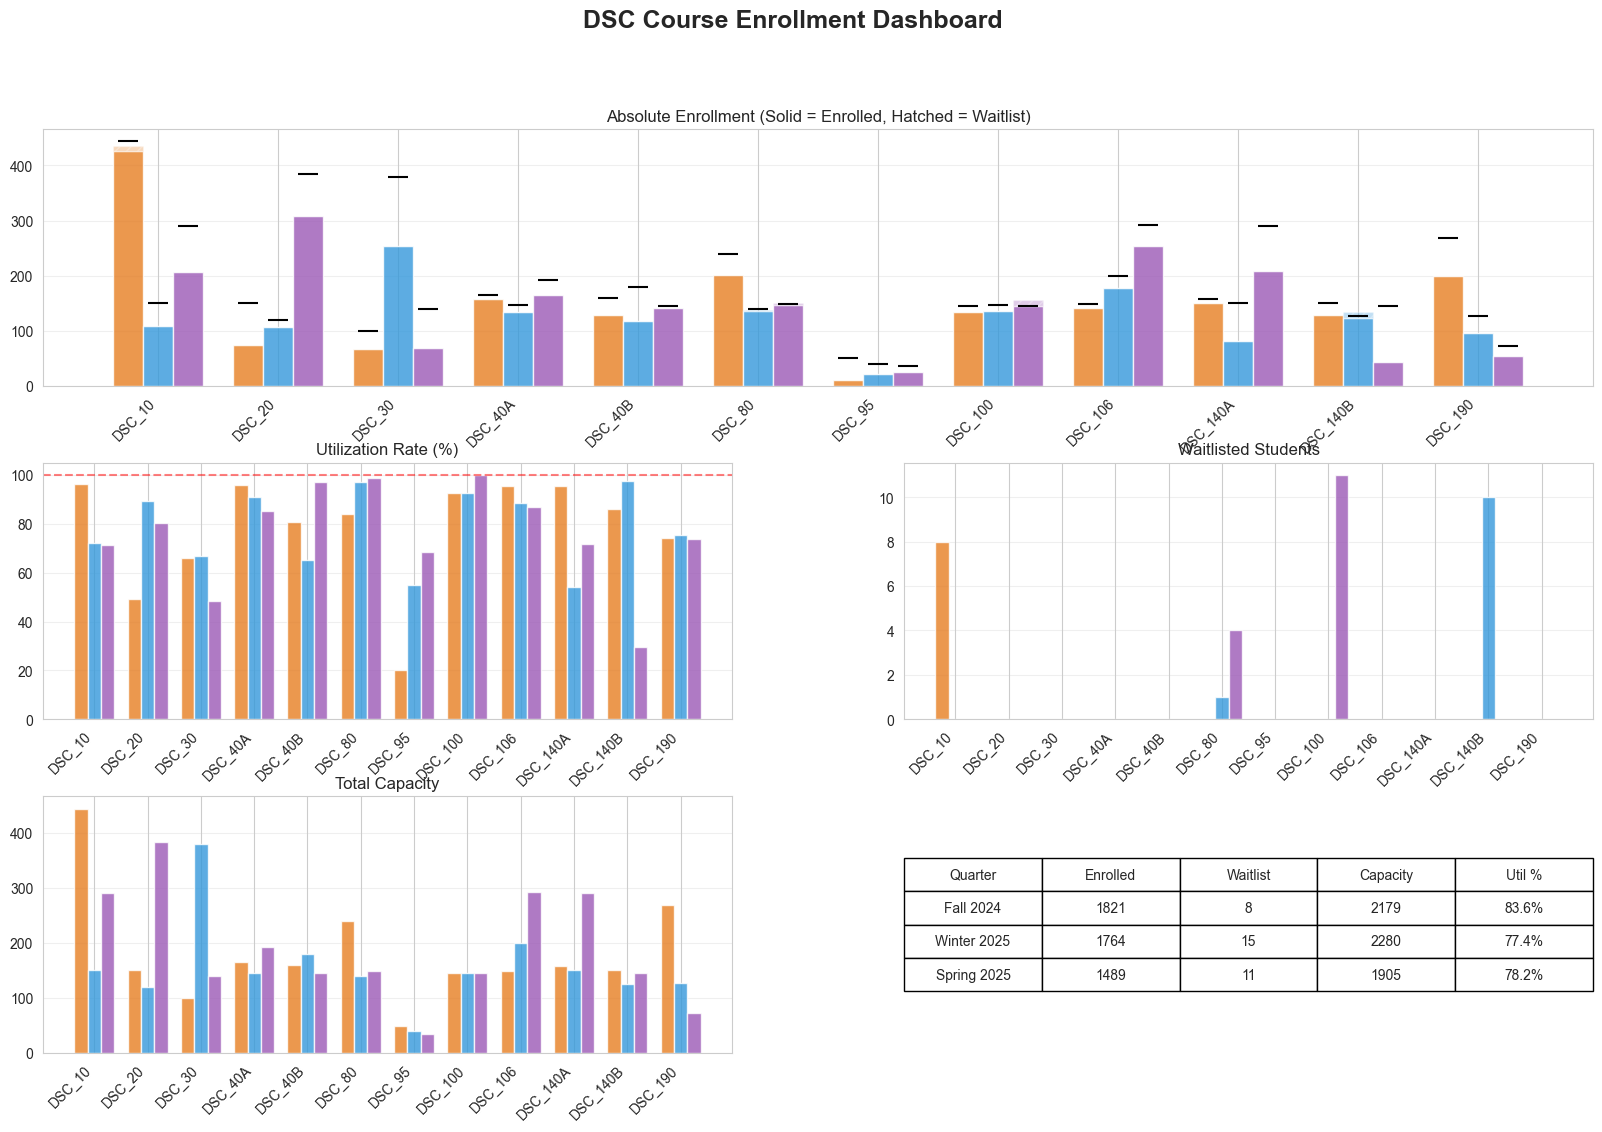

In [11]:
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.25)

# ── Top: Absolute enrollment ──
ax1 = fig.add_subplot(gs[0, :])
for i, quarter in enumerate(['Fall 2024', 'Spring 2025', 'Winter 2025']):
    q = df[df['quarter_label'] == quarter].sort_values('course')
    pos = x + (i - 1) * width

    ax1.bar(pos, q['enrolled'], width, color=quarter_colors[quarter], alpha=0.8)
    ax1.bar(pos, q['waitlisted'], width, bottom=q['enrolled'],
            color=quarter_colors[quarter], alpha=0.3, hatch='///')
    ax1.scatter(pos, q['total'], color='black', marker='_', s=200)

ax1.set_title('Absolute Enrollment (Solid = Enrolled, Hatched = Waitlist)')
ax1.set_xticks(x)
ax1.set_xticklabels(course_order, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# ── Middle left: Utilization ──
ax2 = fig.add_subplot(gs[1, 0])
for i, quarter in enumerate(['Fall 2024', 'Spring 2025', 'Winter 2025']):
    q = df[df['quarter_label'] == quarter].sort_values('course')
    pos = x + (i - 1) * width
    ax2.bar(pos, q['utilization_rate'], width,
            color=quarter_colors[quarter], alpha=0.8)

ax2.axhline(100, color='red', linestyle='--', alpha=0.5)
ax2.set_title('Utilization Rate (%)')
ax2.set_xticks(x)
ax2.set_xticklabels(course_order, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# ── Middle right: Waitlist size ──
ax3 = fig.add_subplot(gs[1, 1])
for i, quarter in enumerate(['Fall 2024', 'Spring 2025', 'Winter 2025']):
    q = df[df['quarter_label'] == quarter].sort_values('course')
    pos = x + (i - 1) * width
    ax3.bar(pos, q['waitlisted'], width,
            color=quarter_colors[quarter], alpha=0.8)

ax3.set_title('Waitlisted Students')
ax3.set_xticks(x)
ax3.set_xticklabels(course_order, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# ── Bottom left: Capacity ──
ax4 = fig.add_subplot(gs[2, 0])
for i, quarter in enumerate(['Fall 2024', 'Spring 2025', 'Winter 2025']):
    q = df[df['quarter_label'] == quarter].sort_values('course')
    pos = x + (i - 1) * width
    ax4.bar(pos, q['total'], width,
            color=quarter_colors[quarter], alpha=0.8)

ax4.set_title('Total Capacity')
ax4.set_xticks(x)
ax4.set_xticklabels(course_order, rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

# ── Bottom right: Summary table ──
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')

summary = []
for q in ['Fall 2024', 'Winter 2025', 'Spring 2025']:
    d = df[df['quarter_label'] == q]
    summary.append([
        q,
        int(d['enrolled'].sum()),
        int(d['waitlisted'].sum()),
        int(d['total'].sum()),
        f"{(d['enrolled'].sum() / d['total'].sum() * 100):.1f}%"
    ])

table = ax5.table(
    cellText=summary,
    colLabels=['Quarter', 'Enrolled', 'Waitlist', 'Capacity', 'Util %'],
    cellLoc='center',
    loc='center'
)
table.scale(1, 2)

fig.suptitle('DSC Course Enrollment Dashboard', fontsize=18, fontweight='bold')
plt.show()


# Visualization 7 — Course-Level Trend Lines

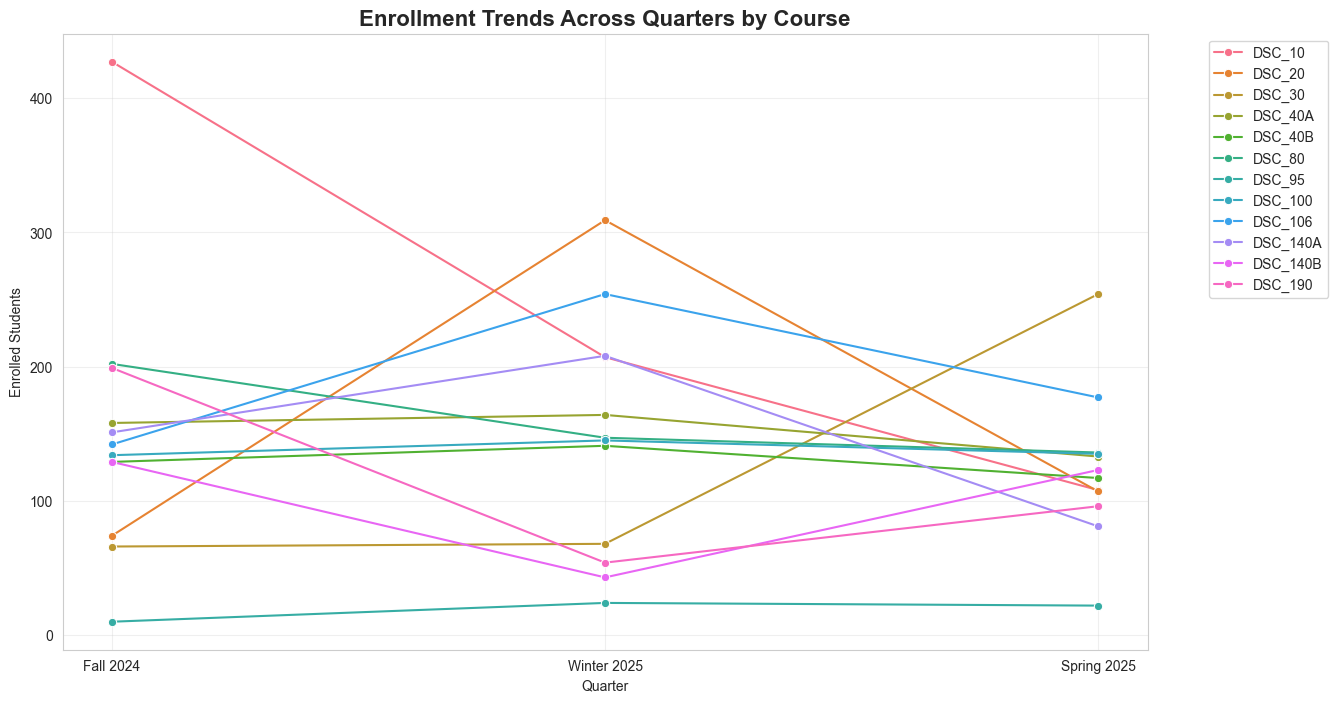

In [12]:
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=df,
    x='quarter_label',
    y='enrolled',
    hue='course',
    marker='o'
)
plt.title('Enrollment Trends Across Quarters by Course', fontsize=16, fontweight='bold')
plt.xlabel('Quarter')
plt.ylabel('Enrolled Students')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.show()


# Visualization 8 — Waitlist-to-Capacity Ratio

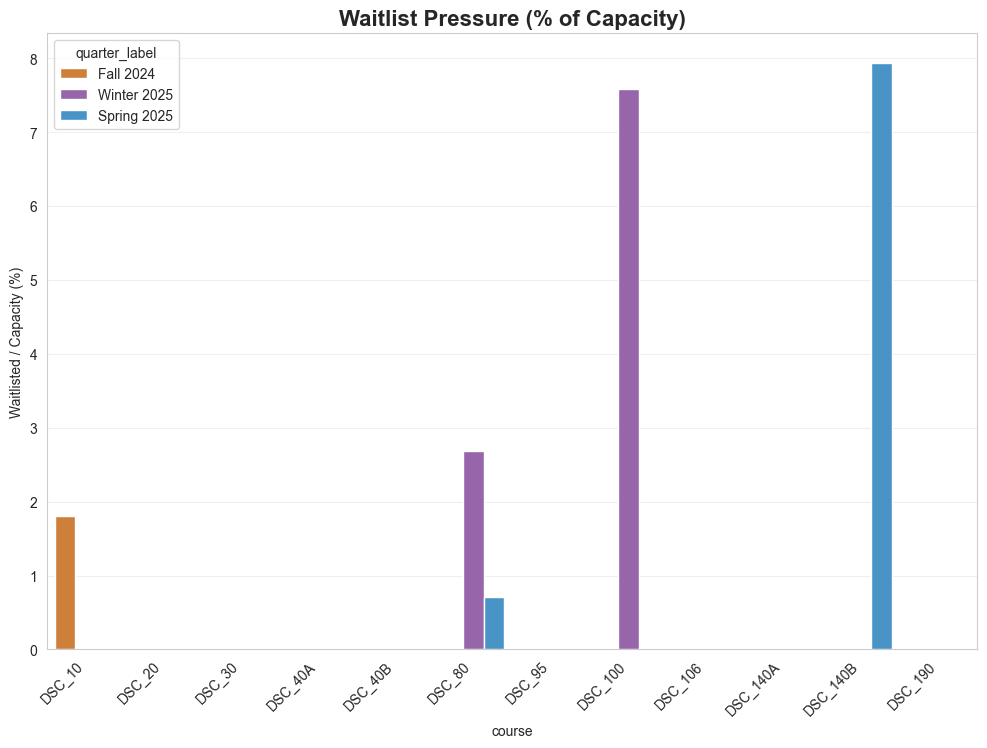

In [13]:
df['waitlist_ratio'] = (df['waitlisted'] / df['total']) * 100

plt.figure(figsize=(12, 8))
sns.barplot(
    data=df,
    x='course',
    y='waitlist_ratio',
    hue='quarter_label',
    palette=quarter_colors
)
plt.title('Waitlist Pressure (% of Capacity)', fontsize=16, fontweight='bold')
plt.ylabel('Waitlisted / Capacity (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.show()


# Visualization 9 — Capacity vs Enrollment Scatter

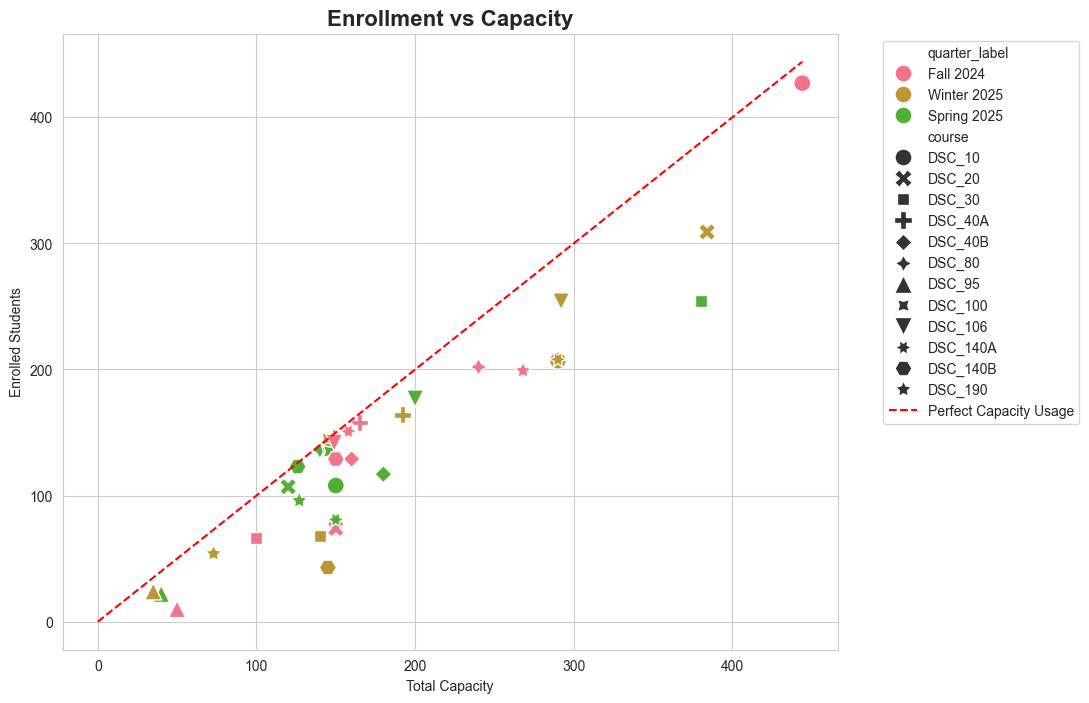

In [14]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x='total',
    y='enrolled',
    hue='quarter_label',
    style='course',
    s=150
)

max_cap = df['total'].max()
plt.plot([0, max_cap], [0, max_cap], 'r--', label='Perfect Capacity Usage')

plt.title('Enrollment vs Capacity', fontsize=16, fontweight='bold')
plt.xlabel('Total Capacity')
plt.ylabel('Enrolled Students')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()


# Visualization 10 — Bottleneck Courses (Top Waitlists)

/var/folders/r8/q05ww6td64s70f879mjv3v540000gn/T/ipykernel_49116/3392836171.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('quarter_label')
/var/folders/r8/q05ww6td64s70f879mjv3v540000gn/T/ipykernel_49116/3392836171.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, 'waitlisted'))


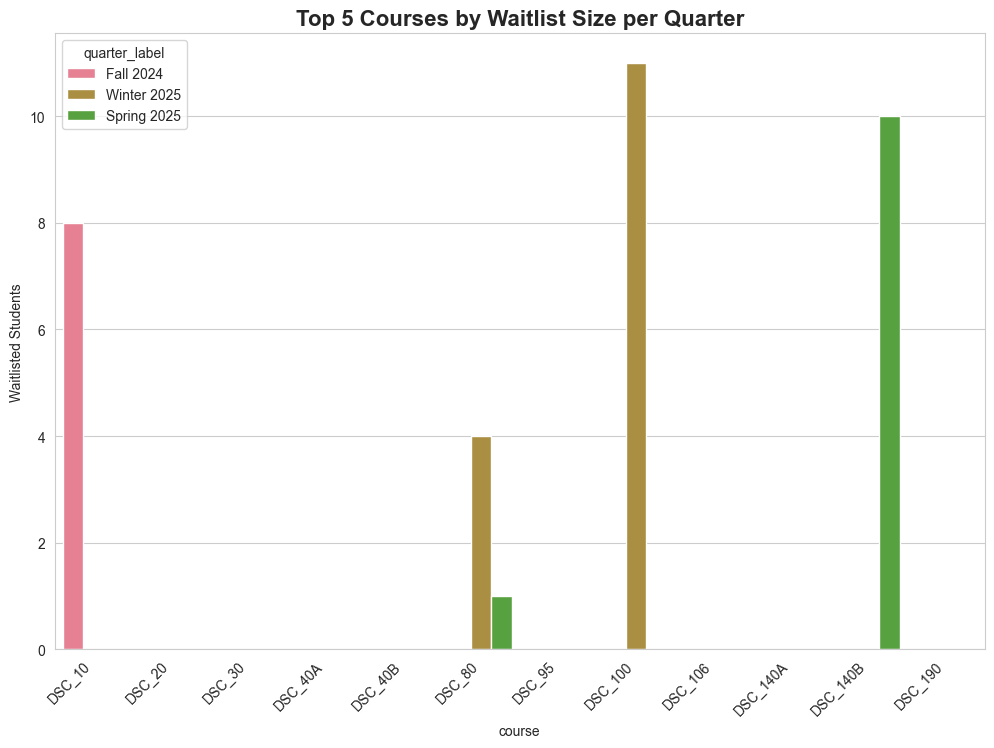

In [15]:
top_waitlist = (
    df.groupby('quarter_label')
      .apply(lambda x: x.nlargest(5, 'waitlisted'))
      .reset_index(drop=True)
)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_waitlist,
    x='course',
    y='waitlisted',
    hue='quarter_label'
)
plt.title('Top 5 Courses by Waitlist Size per Quarter', fontsize=16, fontweight='bold')
plt.ylabel('Waitlisted Students')
plt.xticks(rotation=45, ha='right')
plt.show()


# Visualization 11 — Quarter-over-Quarter Enrollment Change

/var/folders/r8/q05ww6td64s70f879mjv3v540000gn/T/ipykernel_49116/1015258836.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sorted.groupby('course')['enrolled']


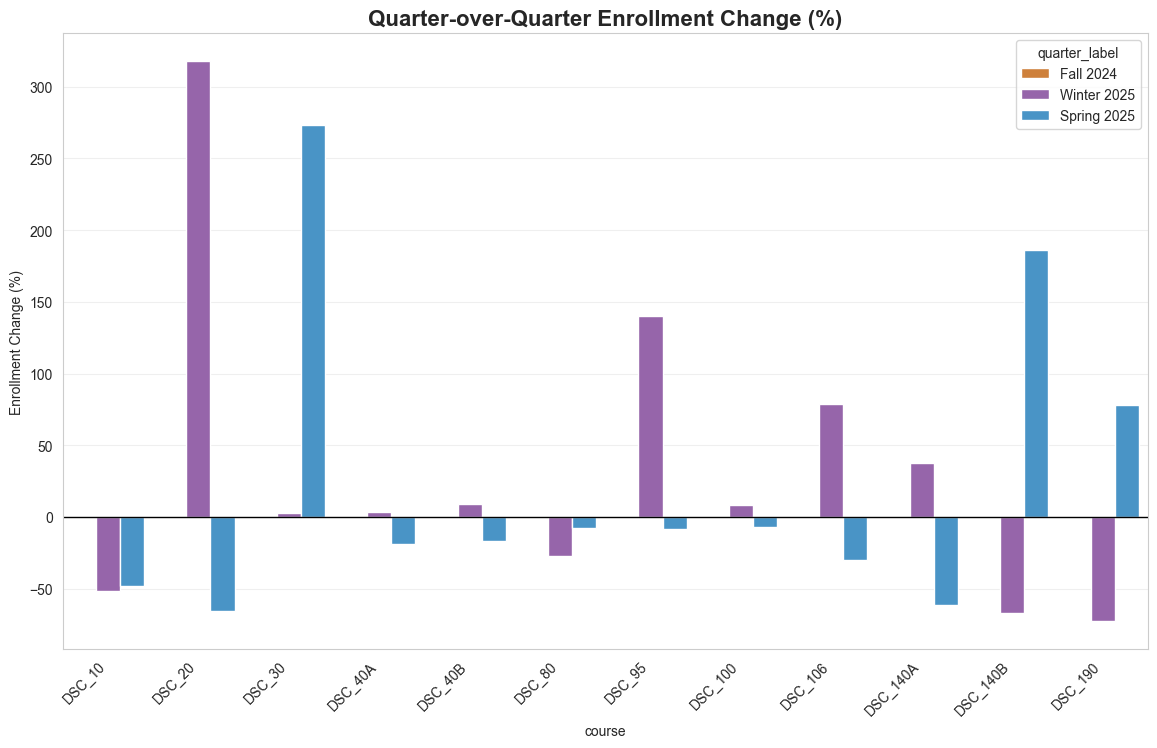

In [16]:
df_sorted = df.sort_values(['course', 'quarter_label'])
df_sorted['enrollment_change'] = (
    df_sorted.groupby('course')['enrolled']
    .pct_change() * 100
)

plt.figure(figsize=(14, 8))
sns.barplot(
    data=df_sorted,
    x='course',
    y='enrollment_change',
    hue='quarter_label',
    palette=quarter_colors
)
plt.axhline(0, color='black', linewidth=1)
plt.title('Quarter-over-Quarter Enrollment Change (%)', fontsize=16, fontweight='bold')
plt.ylabel('Enrollment Change (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.show()


# Visualization 12 — Enrollment vs Capacity

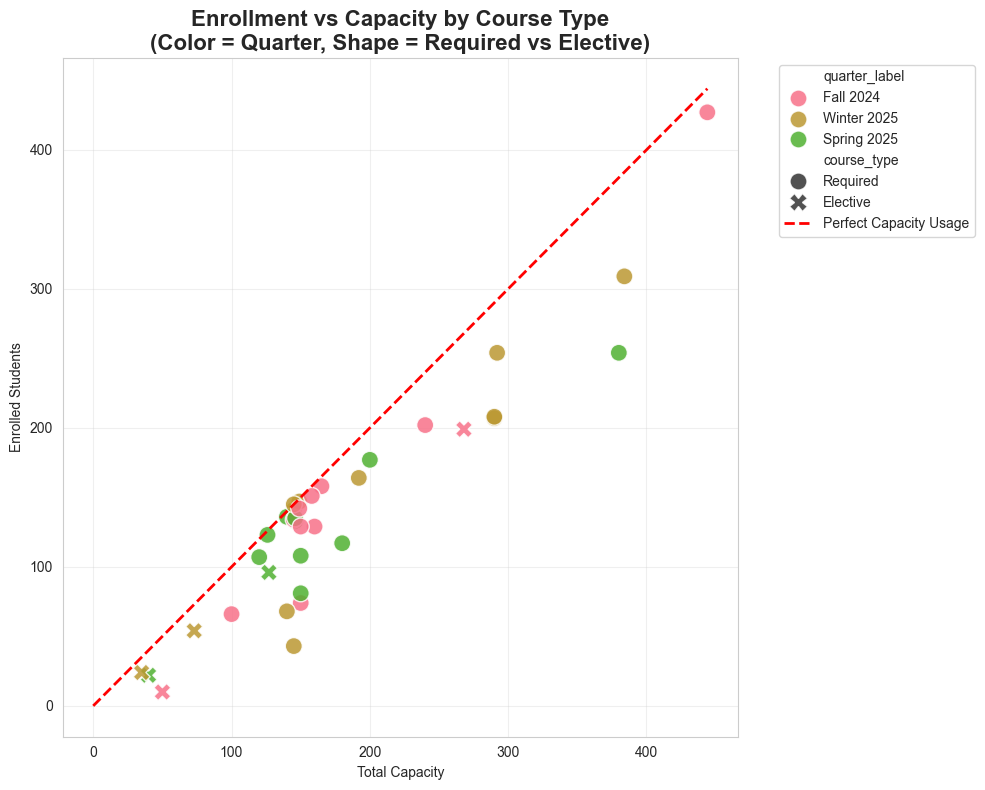

In [19]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=df,
    x='total',
    y='enrolled',
    hue='quarter_label',      # Color → Quarter
    style='course_type',      # Shape → Required vs Elective
    s=150,
    alpha=0.85
)

# Perfect capacity reference
max_cap = df['total'].max()
plt.plot(
    [0, max_cap],
    [0, max_cap],
    'r--',
    linewidth=2,
    label='Perfect Capacity Usage'
)

plt.title(
    'Enrollment vs Capacity by Course Type\n'
    '(Color = Quarter, Shape = Required vs Elective)',
    fontsize=16,
    fontweight='bold'
)
plt.xlabel('Total Capacity')
plt.ylabel('Enrolled Students')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
